In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchsummary import summary
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
from scipy import stats

colors = sns.color_palette('colorblind')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
X, y = np.load('./drive/My Drive/mri_data/tensors.npy'), np.load('./drive/My Drive/mri_data/labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(1113, 1, 58, 70, 58) (1113,)


In [0]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Loading model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)),
    nn.BatchNorm3d(c_out),
    nn.ReLU(),
    nn.MaxPool3d(2)
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear = nn.Linear(128*5*7*5, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
           Linear-14                   

In [6]:
CHECKPOINTS_DIR =  './drive/My Drive/mri_data/checkpoints/'

model.load_state_dict(torch.load(CHECKPOINTS_DIR+'best_model'))

<All keys matched successfully>

## Extraxting features

In [0]:
def count_entropy(t):
    entropy_matrix = np.zeros((t.shape[0], t.shape[1]))
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            hist, _ = np.histogram(t[i, j], bins=255)
            hist = hist / (t.shape[2] * t.shape[3] * t.shape[4])
            loghist = np.log(hist)
            loghist[np.isneginf(loghist)] = 0
            e = -np.sum(hist*loghist)
            entropy_matrix[i, j] = e
    return entropy_matrix

In [0]:
mri_dataset = MriData(X, y)
mri_data_loader = torch.utils.data.DataLoader(mri_dataset, batch_size=47, shuffle=False) 

In [9]:
model.eval()
exists = False

for data, target in mri_data_loader:
    data = data.to(device)
    target = target.to(device)
    features = model.hidden1(data)
    
    #male features
    if exists:
        male_features = np.vstack([male_features, features[torch.where(target == 1)].detach().mean(axis=(2,3,4)).cpu().numpy()])
        male_entropy = np.vstack([male_entropy, count_entropy(features[torch.where(target == 1)].detach().cpu().numpy())])
    else:
        male_features = features[torch.where(target == 1)].detach().mean(axis=(2,3,4)).cpu().numpy()
        male_entropy = count_entropy(features[torch.where(target == 1)].detach().cpu().numpy())

    #female features
    if exists:
        female_features = np.vstack([female_features, features[torch.where(target == 0)].detach().mean(axis=(2,3,4)).cpu().numpy()])
        female_entropy = np.vstack([female_entropy, count_entropy(features[torch.where(target == 0)].detach().cpu().numpy())])
    else:
        female_features = features[torch.where(target == 0)].detach().mean(axis=(2,3,4)).cpu().numpy()
        female_entropy = count_entropy(features[torch.where(target == 0)].detach().cpu().numpy())
        exists = True

    del data, target, features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


## Between-group differencies of 32 features mean voxel values

In [0]:
m = male_features.mean(axis=0)
f = female_features.mean(axis=0)
m_ci = 2*male_features.std(axis=0)/np.sqrt(len(male_features))
f_ci = 2*female_features.std(axis=0)/np.sqrt(len(female_features))

In [11]:
differencies = [None]*32
nb_diffs_male = 0
nb_diffs_female = 0


for i in range(32):
    s, p = stats.ttest_ind(male_features[:, i], female_features[:, i])
    if p < 0.05:
        if s < 0:
            nb_diffs_female += 1
            differencies[i] = -1 #female value is significantly larger
        else:
            nb_diffs_male += 1
            differencies[i] = 1 #male value is significantly larger
    else:
        differencies[i] = 0 #there is no difference

print('Number of features with significantly large difference: {}/32'.format(nb_diffs_female+nb_diffs_male))
print('Number of features with significantly large female values: {}/32'.format(nb_diffs_female))
print('Number of features with significantly large male values: {}/32'.format(nb_diffs_male))

Number of features with significantly large difference: 31/32
Number of features with significantly large female values: 10/32
Number of features with significantly large male values: 21/32


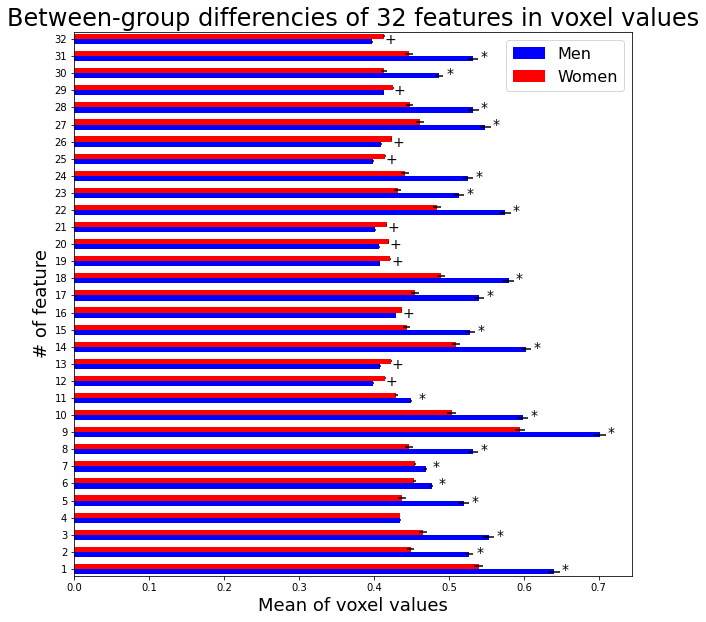

In [12]:
plt.figure(figsize=(10,10))
plt.title('Between-group differencies of 32 features in voxel values', fontsize=24)
plt.xlabel('Mean of voxel values', fontsize=18)
plt.ylabel('# of feature', fontsize=18)

p1 = plt.barh(np.arange(1,33)-0.15 , m, 0.30, color = 'blue', xerr=m_ci)
p2 = plt.barh(np.arange(1,33)+0.15 , f, 0.30, color = 'red', xerr=f_ci)    

for i in range(32):
    if differencies[i] == 0:
        continue
    if differencies[i] == 1:
        xx = m[i]+.010
        symbol = '*' # * - men > women
    else:
        xx = f[i]+.001
        symbol = '+' # + - women > men

    plt.text(xx, i+.71, symbol, fontsize=14)

plt.ylim((0.6, 32.4))
plt.yticks(np.arange(1,33))

plt.legend((p1[0], p2[0]), ('Men', 'Women'), fontsize=16)

plt.savefig('feature_mean_values.png', bbox_inches = 'tight', pad_inches = 0.005, dpi = 300) 

## Between-group differencies of 32 features entropy values

In [0]:
m = male_entropy.mean(axis=0)
f = female_entropy.mean(axis=0)
m_ci = 2*male_entropy.std(axis=0)/np.sqrt(len(male_entropy))
f_ci = 2*female_entropy.std(axis=0)/np.sqrt(len(female_entropy))

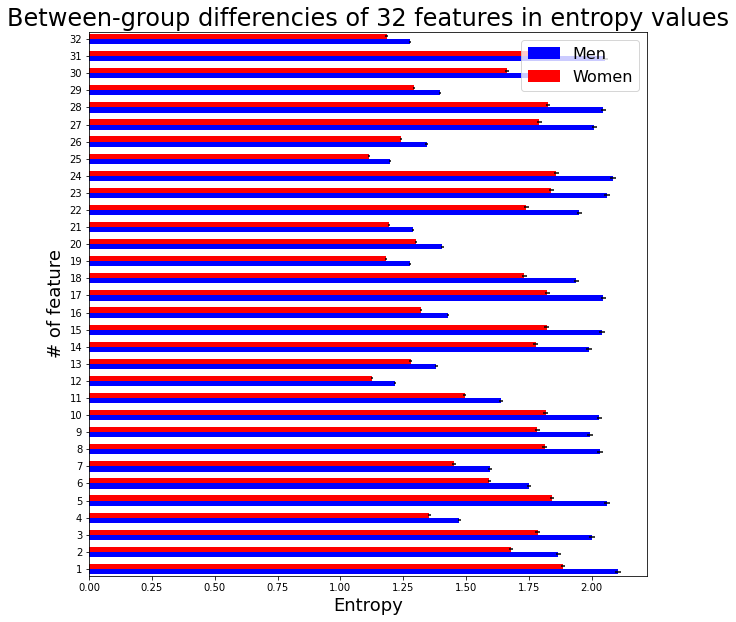

In [14]:
plt.figure(figsize=(10,10))
plt.title('Between-group differencies of 32 features in entropy values', fontsize=24)
plt.xlabel('Entropy', fontsize=18)
plt.ylabel('# of feature', fontsize=18)

p1 = plt.barh(np.arange(1,33)-0.15 , m, 0.30, color = 'blue', xerr=m_ci)
p2 = plt.barh(np.arange(1,33)+0.15 , f, 0.30, color = 'red', xerr=f_ci)      

plt.ylim((0.6, 32.4))
plt.yticks(np.arange(1,33))

plt.legend((p1[0], p2[0]), ('Men', 'Women'), fontsize=16)

plt.savefig('feature_entropy.png', bbox_inches = 'tight', pad_inches = 0.005, dpi = 300) 